In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

### 데이터 불러오기

In [2]:
df = pd.read_excel('onion_after2020_combined.xlsx')
df.head()

,date_time,상품중품평균가격,자동차용경유,평균풍속(m/s)_통영,일조율(%)_통영,평균풍속(m/s)_울진,일조율(%)_울진,평균풍속(m/s)_여수,일조율(%)_여수,평균기온(℃),...,연단위생산량(톤),month,월단위생산량(kg),소비자물가지수,신선야채지수,생활물가지수,식품생활지수,0.5M 평균 습도(%),50CM 일 토양수분(%),얕은평균토양수분
0,2020-01-01,10462.5,1392.26,2.1,80.8,3.4,92.8,4.4,90.9,-4.0,...,1168227,1,111384.166667,0.090000,0.620000,0.360000,-2.060000,51.0,10.0,17.333333
1,2020-01-02,10500.0,1392.88,1.7,78.8,2.9,92.8,3.5,86.9,-1.7,...,1168227,1,112483.704301,0.092258,0.511613,0.362258,-2.065161,52.0,10.0,17.333333
2,2020-01-03,11025.0,1393.16,1.6,78.8,2.6,91.8,6.3,88.9,-3.5,...,1168227,1,113583.241935,0.094516,0.403226,0.364516,-2.070323,51.0,10.0,16.666667
3,2020-01-04,11325.0,1393.82,1.4,79.8,3.2,85.6,4.8,85.9,-2.0,...,1168227,1,114682.779570,0.096774,0.294839,0.366774,-2.075484,53.0,10.0,16.666667
4,2020-01-05,11625.0,1394.03,1.6,74.7,2.2,87.6,1.7,82.8,-2.4,...,1168227,1,115782.317204,0.099032,0.186452,0.369032,-2.080645,52.0,10.0,16.666667


### df에 year, month 컬럼 추가 

In [3]:
df['year'] = pd.DatetimeIndex(df['date_time']).year
df['month'] = pd.DatetimeIndex(df['date_time']).month

# 1,2개월 전 최대값 -> 폭풍, 더위와 같이 최대값이 중요한 지표

In [4]:
for i in [2,3]:
    for col_name in ['강수량(mm)', '평균기온(℃)', '평균풍속(m/s)','평균풍속(m/s)_통영','평균풍속(m/s)_울진','평균풍속(m/s)_여수']:   
        ##### 각 행에 1,2개월 전의 최대 값 추가하기
        # 새로운 df에 각 월의 최대 값을 구한 후, 값을 한 달씩 뒤로 미룸 -> 전월의 최대값을 나타내도록
        monthly_max = df.groupby(pd.Grouper(key='date_time', freq='MS'))[str(col_name)].max()
        monthly_max = monthly_max.shift(periods=i, freq='M').reset_index()

        # 새로운 df에 year, month 컬럼 추가
        monthly_max['year'] = pd.DatetimeIndex(monthly_max['date_time']).year
        monthly_max['month'] = pd.DatetimeIndex(monthly_max['date_time']).month

        # 새로 생긴 컬럼 이름을 바꿔줌
        monthly_max = monthly_max.rename(columns={str(col_name): str(i-1)+'개월전최대'+str(col_name)})

        # 새로 만든 컬럼을 연도 및 월을 기준으로 원래 데이터 프레임과 병합
        df = pd.merge(df, monthly_max, on=['year', 'month'], how='left')

        # 겹치는 date_time 제거
        df = df.rename(columns={'date_time_x': 'date_time'})
        df = df.drop('date_time_y', axis=1)


# 양파 키우는 기간 동안의 기상 & 토양 환경, 농기계에 쓰인 경유 가격

In [5]:
for i in range(0,6):
    for col_name in ['자동차용경유', '평균습도(%rh)','강수량(mm)', '일조합(hr)', '평균기온(℃)', '일조율(%)', '평균풍속(m/s)',
            '일교차', '0.5M 평균 습도(%)', '얕은평균토양수분']:   
        ##### 각 행에 1,2,3,4,5,6개월 전의 평균 값 추가하기
        # 새로운 df에 각 월의 평균 값을 구한 후, 값을 한 달씩 뒤로 미룸 -> 전월의 평균값을 나타내도록
        monthly_mean = df.groupby(pd.Grouper(key='date_time', freq='MS'))[str(col_name)].mean()
        monthly_mean = monthly_mean.shift(periods=i+2, freq='M').reset_index()

        # 새로운 df에 year, month 컬럼 추가
        monthly_mean['year'] = pd.DatetimeIndex(monthly_mean['date_time']).year
        monthly_mean['month'] = pd.DatetimeIndex(monthly_mean['date_time']).month

        # 새로 생긴 컬럼 이름을 바꿔줌
        monthly_mean = monthly_mean.rename(columns={str(col_name): str(i+1)+'개월전'+str(col_name)})

        # 새로 만든 컬럼을 연도 및 월을 기준으로 원래 데이터 프레임과 병합
        df = pd.merge(df, monthly_mean, on=['year', 'month'], how='left')

        # 겹치는 date_time 제거
        df = df.rename(columns={'date_time_x': 'date_time'})
        df = df.drop('date_time_y', axis=1)


# 작년의 재배면적 & 면적당 생산량 & 총생산량 -> 다음 재배 계획에 영향

In [6]:
for col_name in ['재배면적합계(ha)', '10a당생산량(kg)', '연단위생산량(톤)']:   
    ##### 각 행에 1년 전의 평균 값 추가하기
    # 새로운 df에 각 월의 평균 값을 구한 후, 값을 한 달씩 뒤로 미룸 -> 전월의 평균값을 나타내도록
    last_year_mean = df.groupby(pd.Grouper(key='date_time', freq='MS'))[str(col_name)].mean()
    last_year_mean = last_year_mean.shift(periods=13, freq='M').reset_index()

    # 새로운 df에 year, month 컬럼 추가
    last_year_mean['year'] = pd.DatetimeIndex(last_year_mean['date_time']).year
    last_year_mean['month'] = pd.DatetimeIndex(last_year_mean['date_time']).month

    # 새로 생긴 컬럼 이름을 바꿔줌
    last_year_mean = last_year_mean.rename(columns={str(col_name): '1년전'+str(col_name)})

    # 새로 만든 컬럼을 연도 및 월을 기준으로 원래 데이터 프레임과 병합
    df = pd.merge(df, last_year_mean, on=['year', 'month'], how='left')

    # 겹치는 date_time 제거
    df = df.rename(columns={'date_time_x': 'date_time'})
    df = df.drop('date_time_y', axis=1)

# 1개월, N년 전 상품중품평균가격 -> 같은 시기의 가격 반영

In [7]:
for i in [2,13, 25, 37, 49, 61, 73, 85, 97, 109]:
    for col_name in ['상품중품평균가격']:   
        ##### 각 행에 1개월, N년 전의 평균 값 추가하기
        # 새로운 df에 각 월의 평균 값을 구한 후, 값을 한 달씩 뒤로 미룸 -> 전월의 평균값을 나타내도록
        monthly_yearly_mean = df.groupby(pd.Grouper(key='date_time', freq='MS'))[str(col_name)].mean()
        monthly_yearly_mean = monthly_yearly_mean.shift(periods=i, freq='M').reset_index()

        # 새로운 df에 year, month 컬럼 추가
        monthly_yearly_mean['year'] = pd.DatetimeIndex(monthly_yearly_mean['date_time']).year
        monthly_yearly_mean['month'] = pd.DatetimeIndex(monthly_yearly_mean['date_time']).month

        # 새로 생긴 컬럼 이름을 바꿔줌
        monthly_yearly_mean = monthly_yearly_mean.rename(columns={str(col_name): str(i-1)+'개월전'+str(col_name)})

        # 새로 만든 컬럼을 연도 및 월을 기준으로 원래 데이터 프레임과 병합
        df = pd.merge(df, monthly_yearly_mean, on=['year', 'month'], how='left')

        # 겹치는 date_time 제거
        df = df.rename(columns={'date_time_x': 'date_time'})
        df = df.drop('date_time_y', axis=1)


# 1,2개월 전 물가지수의 평균값 -> 가격에 영향

In [8]:
for i in [2,3]:
    for col_name in ['월단위생산량(kg)', '소비자물가지수', '신선야채지수', '생활물가지수', '식품생활지수']:   
        ##### 각 행에 1,2개월 전의 평균 값 추가하기
        # 새로운 df에 각 월의 평균 값을 구한 후, 값을 한 달씩 뒤로 미룸 -> 전월의 평균값을 나타내도록
        monthly_mean = df.groupby(pd.Grouper(key='date_time', freq='MS'))[str(col_name)].mean()
        monthly_mean = monthly_mean.shift(periods=i, freq='M').reset_index()

        # 새로운 df에 year, month 컬럼 추가
        monthly_mean['year'] = pd.DatetimeIndex(monthly_mean['date_time']).year
        monthly_mean['month'] = pd.DatetimeIndex(monthly_mean['date_time']).month

        # 새로 생긴 컬럼 이름을 바꿔줌
        monthly_mean = monthly_mean.rename(columns={str(col_name): str(i-1)+'개월전평균'+str(col_name)})

        # 새로 만든 컬럼을 연도 및 월을 기준으로 원래 데이터 프레임과 병합
        df = pd.merge(df, monthly_mean, on=['year', 'month'], how='left')

        # 겹치는 date_time 제거
        df = df.rename(columns={'date_time_x': 'date_time'})
        df = df.drop('date_time_y', axis=1)

# 1개월 전 해당 일자 물가지수의 값 -> 가격에 영향

In [9]:
for col_name in ['월단위생산량(kg)', '소비자물가지수', '신선야채지수', '생활물가지수', '식품생활지수']:
    df1 = df[['date_time', str(col_name)]]

    # date_time을 인덱스로 설정
    df1 = df1.set_index('date_time')
    df1.index = pd.to_datetime(df1.index)

    # 1개월 전 값을 가지도록 31일만큼 데이터 옮김
    df1 = df1[str(col_name)].shift(periods=31, freq='D').reset_index()
    df1 = df1.rename(columns={str(col_name): '1개월전'+str(col_name)})
    df1.head()
    df = pd.merge(df, df1, on=['date_time'], how='left')

In [10]:
df.isnull().sum()

date_time          0
상품중품평균가격           0
자동차용경유             0
평균풍속(m/s)_통영       0
일조율(%)_통영          0
                  ..
1개월전월단위생산량(kg)    31
1개월전소비자물가지수       31
1개월전신선야채지수        31
1개월전생활물가지수        31
1개월전식품생활지수        31
Length: 132, dtype: int64

In [11]:
df.head()

,date_time,상품중품평균가격,자동차용경유,평균풍속(m/s)_통영,일조율(%)_통영,평균풍속(m/s)_울진,일조율(%)_울진,평균풍속(m/s)_여수,일조율(%)_여수,평균기온(℃),...,2개월전평균월단위생산량(kg),2개월전평균소비자물가지수,2개월전평균신선야채지수,2개월전평균생활물가지수,2개월전평균식품생활지수,1개월전월단위생산량(kg),1개월전소비자물가지수,1개월전신선야채지수,1개월전생활물가지수,1개월전식품생활지수
0,2020-01-01,10462.5,1392.26,2.1,80.8,3.4,92.8,4.4,90.9,-4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-02,10500.0,1392.88,1.7,78.8,2.9,92.8,3.5,86.9,-1.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-03,11025.0,1393.16,1.6,78.8,2.6,91.8,6.3,88.9,-3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-04,11325.0,1393.82,1.4,79.8,3.2,85.6,4.8,85.9,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-05,11625.0,1394.03,1.6,74.7,2.2,87.6,1.7,82.8,-2.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
new_df=df.copy()
new_df = new_df.set_index('date_time')
new_df

,상품중품평균가격,자동차용경유,평균풍속(m/s)_통영,일조율(%)_통영,평균풍속(m/s)_울진,일조율(%)_울진,평균풍속(m/s)_여수,일조율(%)_여수,평균기온(℃),최고기온(℃),...,2개월전평균월단위생산량(kg),2개월전평균소비자물가지수,2개월전평균신선야채지수,2개월전평균생활물가지수,2개월전평균식품생활지수,1개월전월단위생산량(kg),1개월전소비자물가지수,1개월전신선야채지수,1개월전생활물가지수,1개월전식품생활지수
date_time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,10462.5,1392.26,2.1,80.8,3.4,92.8,4.4,90.9,-4.0,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,10500.0,1392.88,1.7,78.8,2.9,92.8,3.5,86.9,-1.7,3.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,11025.0,1393.16,1.6,78.8,2.6,91.8,6.3,88.9,-3.5,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,11325.0,1393.82,1.4,79.8,3.2,85.6,4.8,85.9,-2.0,6.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,11625.0,1394.03,1.6,74.7,2.2,87.6,1.7,82.8,-2.4,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,22340.0,1864.82,2.4,85.3,2.3,0.0,2.9,89.0,10.5,19.6,...,63669.724731,8.770000,32.633226,10.669355,15.012258,53235.704444,9.172667,22.988,11.140,14.80
2022-10-29,22340.0,1866.42,2.5,75.2,1.8,25.0,4.1,84.4,11.7,19.8,...,63669.724731,8.770000,32.633226,10.669355,15.012258,52945.236667,9.182000,22.381,11.145,14.77
2022-10-30,22340.0,1867.15,2.2,62.0,1.6,4.7,4.5,90.8,11.9,20.3,...,63669.724731,8.770000,32.633226,10.669355,15.012258,52654.768889,9.191333,21.774,11.150,14.74


# Train Test Split

In [13]:
from sklearn.model_selection import TimeSeriesSplit

# test data가 30일씩 되도록 6번 반복
tss = TimeSeriesSplit(n_splits=6, test_size=30, gap=0)
new_df = new_df.sort_index()

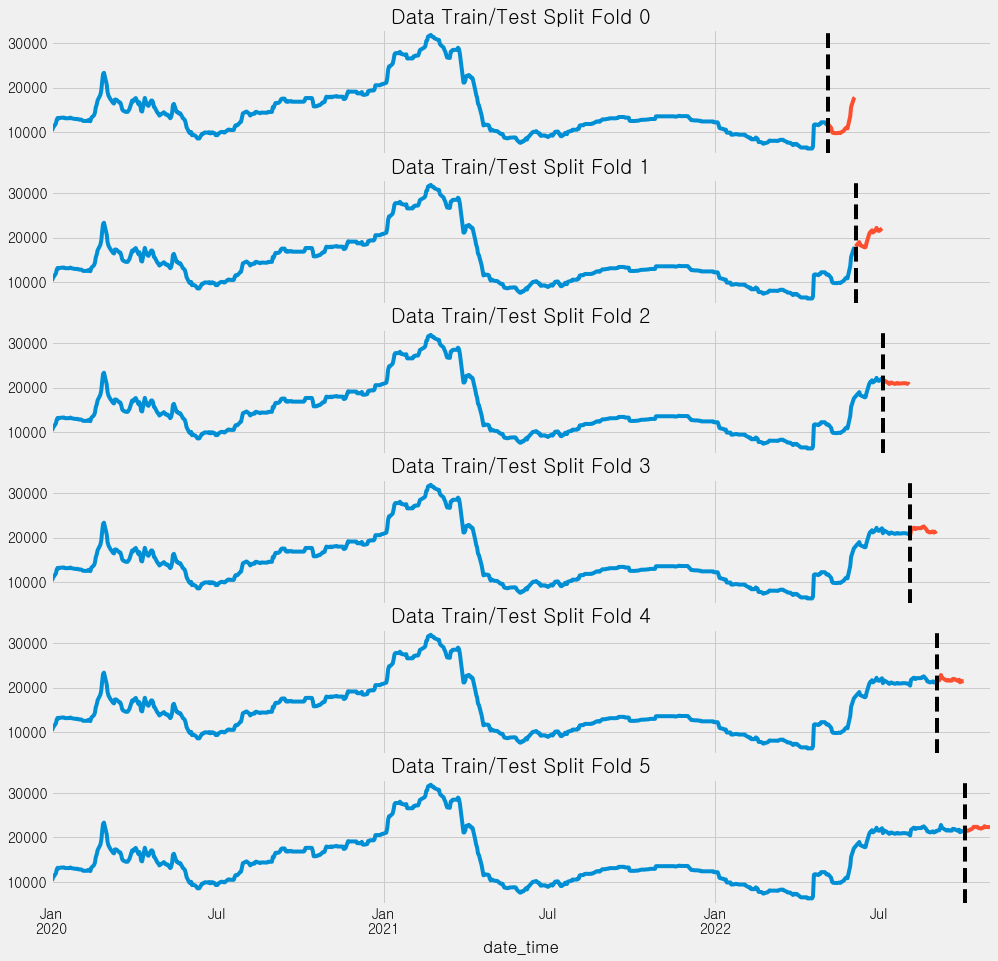

In [14]:
fig, axs = plt.subplots(6, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(new_df):
    train = new_df.iloc[train_idx]
    test = new_df.iloc[val_idx]
    train['상품중품평균가격'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['상품중품평균가격'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


# 날짜 정보 추가 (요일, 월, 연도, 분기 등)

In [15]:
new_df = new_df.reset_index()
new_df['date_time'] = pd.to_datetime(new_df['date_time'])
new_df = new_df.set_index('date_time')

# 달, 주, 일 정보 추가
def create_features(new_df):
    """
    Create time series features based on time series index.
    """
    new_df = new_df.copy()
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['quarter'] = new_df.index.quarter
    new_df['month'] = new_df.index.month
    new_df['year'] = new_df.index.year
    new_df['dayofyear'] = new_df.index.dayofyear
    new_df['dayofmonth'] = new_df.index.day
    return new_df

new_df = create_features(new_df)

new_df.head(3)

,상품중품평균가격,자동차용경유,평균풍속(m/s)_통영,일조율(%)_통영,평균풍속(m/s)_울진,일조율(%)_울진,평균풍속(m/s)_여수,일조율(%)_여수,평균기온(℃),최고기온(℃),...,2개월전평균식품생활지수,1개월전월단위생산량(kg),1개월전소비자물가지수,1개월전신선야채지수,1개월전생활물가지수,1개월전식품생활지수,dayofweek,quarter,dayofyear,dayofmonth
date_time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,10462.5,1392.26,2.1,80.8,3.4,92.8,4.4,90.9,-4.0,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1,1
2020-01-02,10500.0,1392.88,1.7,78.8,2.9,92.8,3.5,86.9,-1.7,3.2,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,2
2020-01-03,11025.0,1393.16,1.6,78.8,2.6,91.8,6.3,88.9,-3.5,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,4,1,3,3


# 모든변수 넣은 1개월 후 예측모델

[0]	validation_0-rmse:15436.16942	validation_1-rmse:11841.04945
[100]	validation_0-rmse:5871.47904	validation_1-rmse:6071.13149
[200]	validation_0-rmse:2402.43369	validation_1-rmse:3977.51434
[300]	validation_0-rmse:1258.95052	validation_1-rmse:3318.14580
[400]	validation_0-rmse:895.61712	validation_1-rmse:2898.08965
[500]	validation_0-rmse:746.39285	validation_1-rmse:2793.58602
[600]	validation_0-rmse:685.73408	validation_1-rmse:2740.56296
[683]	validation_0-rmse:628.20101	validation_1-rmse:2759.02845


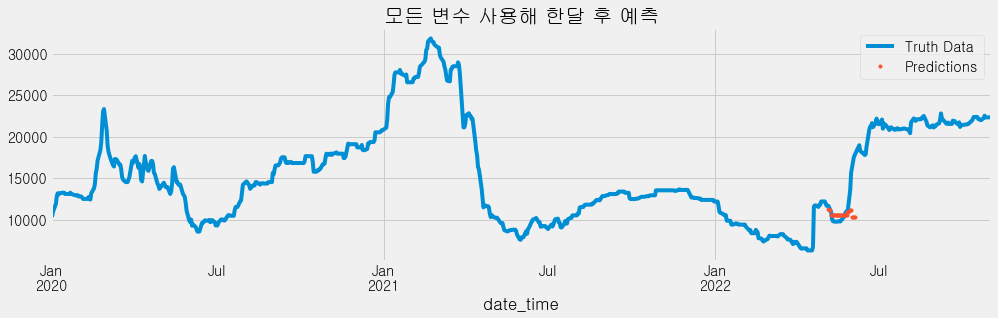

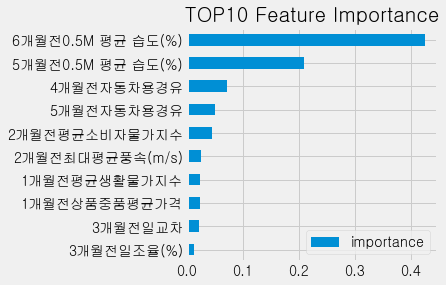

[0]	validation_0-rmse:15327.72574	validation_1-rmse:19988.15994
[100]	validation_0-rmse:5844.93955	validation_1-rmse:13039.57763
[200]	validation_0-rmse:2419.62128	validation_1-rmse:9717.52524
[300]	validation_0-rmse:1294.92228	validation_1-rmse:7385.00749
[400]	validation_0-rmse:957.90461	validation_1-rmse:5982.48054
[500]	validation_0-rmse:799.62646	validation_1-rmse:5435.22815
[600]	validation_0-rmse:719.43701	validation_1-rmse:5199.60938
[700]	validation_0-rmse:660.93662	validation_1-rmse:5051.46300
[800]	validation_0-rmse:609.65946	validation_1-rmse:4951.15777
[900]	validation_0-rmse:557.60618	validation_1-rmse:4874.98983
[1000]	validation_0-rmse:516.62977	validation_1-rmse:4819.01905
[1100]	validation_0-rmse:484.93284	validation_1-rmse:4809.03007
[1200]	validation_0-rmse:456.50401	validation_1-rmse:4786.41984
[1300]	validation_0-rmse:433.40100	validation_1-rmse:4769.44384
[1400]	validation_0-rmse:415.34901	validation_1-rmse:4757.79649
[1500]	validation_0-rmse:397.83716	validation

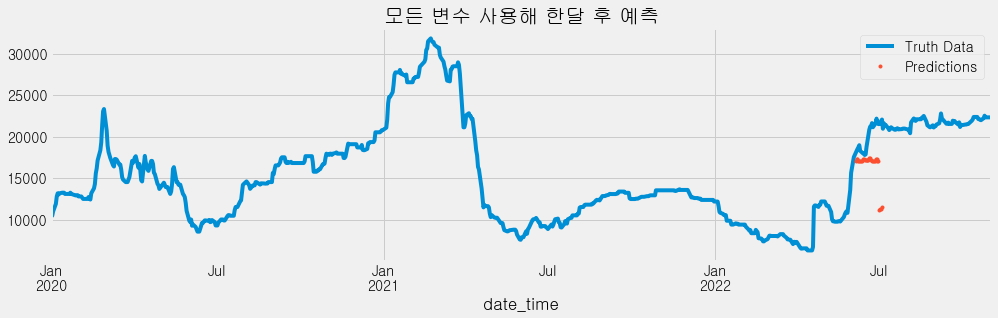

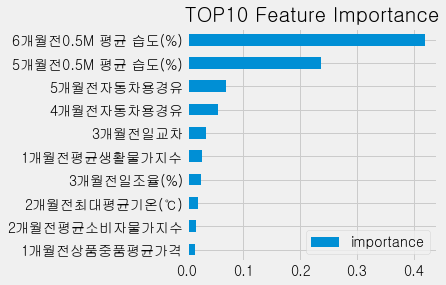

[0]	validation_0-rmse:15498.98408	validation_1-rmse:20829.73923
[100]	validation_0-rmse:5933.95331	validation_1-rmse:10073.82570
[200]	validation_0-rmse:2478.22836	validation_1-rmse:4897.42528
[300]	validation_0-rmse:1345.96732	validation_1-rmse:3047.30216
[400]	validation_0-rmse:1005.09355	validation_1-rmse:2679.00490
[500]	validation_0-rmse:844.65444	validation_1-rmse:2399.40437
[600]	validation_0-rmse:761.24093	validation_1-rmse:2341.62112
[700]	validation_0-rmse:708.01873	validation_1-rmse:2326.83553
[769]	validation_0-rmse:675.09796	validation_1-rmse:2331.19624


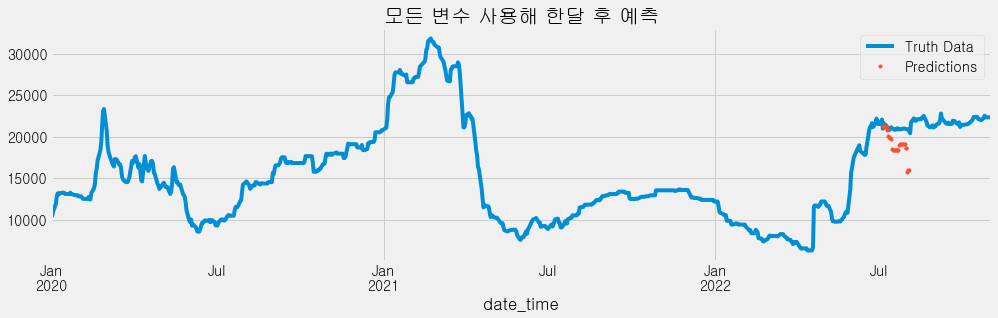

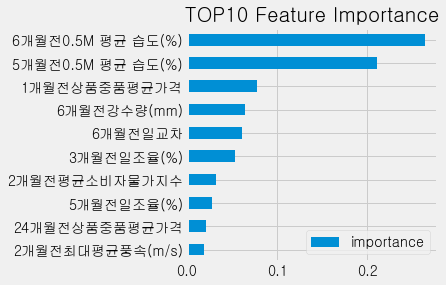

[0]	validation_0-rmse:15694.41577	validation_1-rmse:21557.34772
[100]	validation_0-rmse:5978.81903	validation_1-rmse:9096.87305
[200]	validation_0-rmse:2488.59284	validation_1-rmse:4214.21730
[300]	validation_0-rmse:1354.96045	validation_1-rmse:2586.28297
[400]	validation_0-rmse:1010.02090	validation_1-rmse:2014.29441
[500]	validation_0-rmse:845.68367	validation_1-rmse:1711.82193
[600]	validation_0-rmse:753.77674	validation_1-rmse:1555.64138
[700]	validation_0-rmse:699.66466	validation_1-rmse:1395.98972
[800]	validation_0-rmse:638.44925	validation_1-rmse:1325.45009
[900]	validation_0-rmse:593.45875	validation_1-rmse:1258.87645
[1000]	validation_0-rmse:559.20913	validation_1-rmse:1234.92390
[1100]	validation_0-rmse:531.86462	validation_1-rmse:1211.23303
[1200]	validation_0-rmse:503.05526	validation_1-rmse:1195.34618
[1300]	validation_0-rmse:480.02956	validation_1-rmse:1178.76203
[1400]	validation_0-rmse:454.93048	validation_1-rmse:1167.05279
[1411]	validation_0-rmse:451.76636	validation

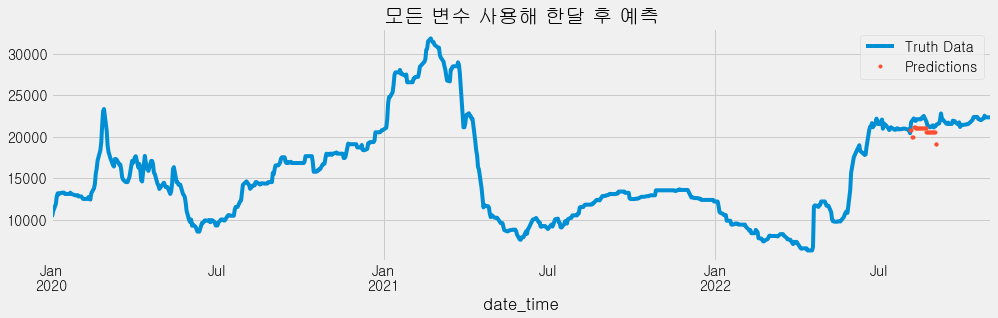

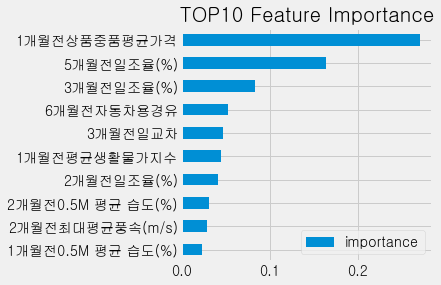

[0]	validation_0-rmse:15905.74405	validation_1-rmse:21503.26070
[100]	validation_0-rmse:6050.08962	validation_1-rmse:8549.60810
[200]	validation_0-rmse:2507.12787	validation_1-rmse:3363.87541
[300]	validation_0-rmse:1357.47855	validation_1-rmse:1181.17903
[400]	validation_0-rmse:992.37098	validation_1-rmse:604.04820
[500]	validation_0-rmse:824.69349	validation_1-rmse:470.39608
[600]	validation_0-rmse:741.95287	validation_1-rmse:455.93429
[681]	validation_0-rmse:700.43797	validation_1-rmse:460.21896


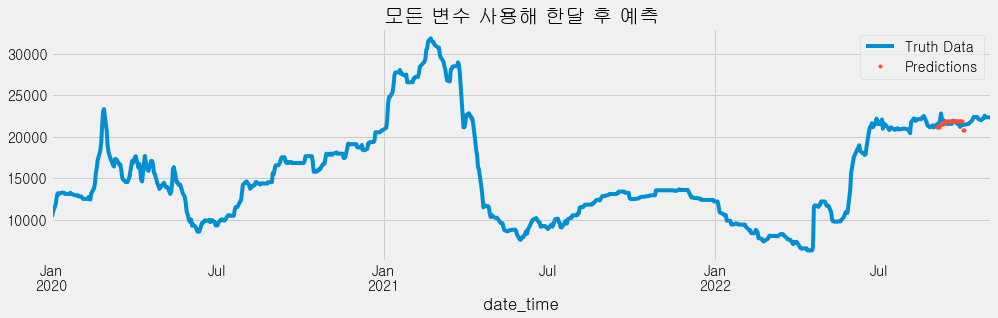

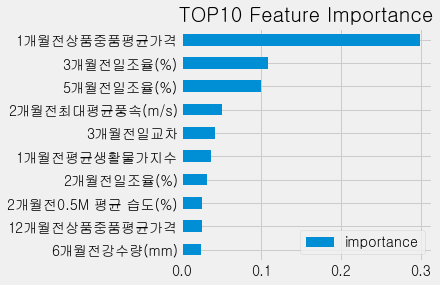

[0]	validation_0-rmse:16100.40998	validation_1-rmse:21874.63335
[100]	validation_0-rmse:6113.60451	validation_1-rmse:8723.09363
[200]	validation_0-rmse:2520.73946	validation_1-rmse:3676.83863
[300]	validation_0-rmse:1341.32138	validation_1-rmse:1705.82047
[400]	validation_0-rmse:977.23796	validation_1-rmse:1131.12975
[500]	validation_0-rmse:815.61394	validation_1-rmse:911.13367
[600]	validation_0-rmse:729.12263	validation_1-rmse:826.94560
[700]	validation_0-rmse:672.18389	validation_1-rmse:794.29871
[800]	validation_0-rmse:633.05507	validation_1-rmse:768.93305
[900]	validation_0-rmse:598.84995	validation_1-rmse:756.69166
[984]	validation_0-rmse:576.27650	validation_1-rmse:756.57404


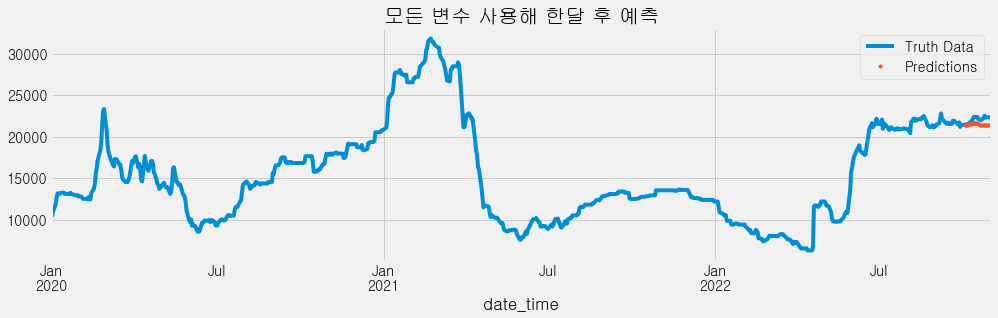

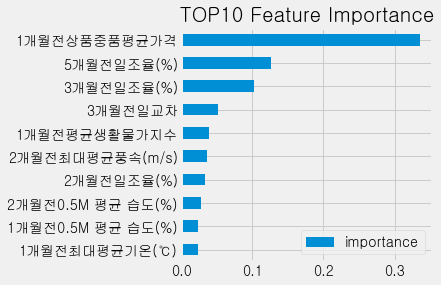

In [16]:
tss = TimeSeriesSplit(n_splits=6, test_size=30*1, gap=0)
new_df = new_df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(new_df):
    new_df2 = new_df.copy()
    train = new_df.iloc[train_idx]
    test = new_df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)


    FEATURES = [
            '1개월전최대강수량(mm)', '1개월전최대평균기온(℃)', '1개월전최대평균풍속(m/s)',
            '2개월전최대강수량(mm)', '2개월전최대평균기온(℃)', '2개월전최대평균풍속(m/s)',
            'month', 'dayofweek', 'quarter', 'dayofyear', '월단위생산량(kg)',
            '1개월전상품중품평균가격',
            '12개월전상품중품평균가격', '24개월전상품중품평균가격', '36개월전상품중품평균가격',
            '48개월전상품중품평균가격', '60개월전상품중품평균가격', '72개월전상품중품평균가격',
            '84개월전상품중품평균가격', '96개월전상품중품평균가격', '108개월전상품중품평균가격',
            '1개월전평균월단위생산량(kg)','1개월전평균소비자물가지수', '1개월전평균생활물가지수',
            '1개월전평균신선야채지수', '1개월전평균식품생활지수',
            '2개월전평균월단위생산량(kg)','2개월전평균소비자물가지수', '2개월전평균생활물가지수',
            '2개월전평균신선야채지수', '2개월전평균식품생활지수',
            '1개월전자동차용경유', '1개월전평균습도(%rh)','1개월전강수량(mm)', '1개월전일조합(hr)', '1개월전일조율(%)',
            '1개월전평균기온(℃)','1개월전일교차', '1개월전평균풍속(m/s)', '1개월전0.5M 평균 습도(%)', '1개월전얕은평균토양수분',
            '2개월전자동차용경유', '2개월전평균습도(%rh)','2개월전강수량(mm)', '2개월전일조합(hr)', '2개월전일조율(%)',
            '2개월전평균기온(℃)', '2개월전일교차', '2개월전평균풍속(m/s)', '2개월전0.5M 평균 습도(%)', '2개월전얕은평균토양수분',
            '3개월전자동차용경유', '3개월전평균습도(%rh)','3개월전강수량(mm)', '3개월전일조합(hr)', '3개월전일조율(%)',
            '3개월전평균기온(℃)', '3개월전일교차', '3개월전평균풍속(m/s)', '3개월전0.5M 평균 습도(%)', '3개월전얕은평균토양수분',
            '4개월전자동차용경유', '4개월전평균습도(%rh)','4개월전강수량(mm)', '4개월전일조합(hr)', '4개월전일조율(%)',
            '4개월전평균기온(℃)', '4개월전일교차', '4개월전평균풍속(m/s)', '4개월전0.5M 평균 습도(%)', '4개월전얕은평균토양수분',
            '5개월전자동차용경유', '5개월전평균습도(%rh)','5개월전강수량(mm)', '5개월전일조합(hr)', '5개월전일조율(%)',
            '5개월전평균기온(℃)', '5개월전일교차', '5개월전평균풍속(m/s)', '5개월전0.5M 평균 습도(%)', '5개월전얕은평균토양수분',
            '6개월전자동차용경유', '6개월전평균습도(%rh)','6개월전강수량(mm)', '6개월전일조합(hr)', '6개월전일조율(%)',
            '6개월전평균기온(℃)', '6개월전일교차', '6개월전평균풍속(m/s)', '6개월전0.5M 평균 습도(%)', '6개월전얕은평균토양수분',
            '재배면적합계(ha)','1년전10a당생산량(kg)', '1년전재배면적합계(ha)'
            ]
    TARGET = '상품중품평균가격'
    

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
    test['prediction'] = reg.predict(X_test)
    new_df2 = new_df2.merge(test[['prediction']], how='left', left_index=True, right_index=True)
    ax = new_df2[['상품중품평균가격']].plot(figsize=(15, 4))
    new_df2['prediction'].plot(ax=ax, style='.')
    plt.legend(['Truth Data', 'Predictions'])
    ax.set_title('모든 변수 사용해 한달 후 예측')
    plt.show()
    
    # Feature Importance plot
    fi = pd.DataFrame(data=reg.feature_importances_,
                 index=reg.feature_names_in_,
                 columns=['importance'])

    fi.sort_values('importance').tail(10).plot(kind='barh', title='TOP10 Feature Importance',figsize=(4,4))
    plt.show()

# 변수 선택 한 1개월 후 예측모델

[0]	validation_0-rmse:15436.71302	validation_1-rmse:11817.86178
[100]	validation_0-rmse:5905.85654	validation_1-rmse:4889.25626
[200]	validation_0-rmse:2528.16197	validation_1-rmse:3077.97508
[300]	validation_0-rmse:1459.31725	validation_1-rmse:2613.00922
[400]	validation_0-rmse:1158.68064	validation_1-rmse:2454.83304
[500]	validation_0-rmse:1001.75425	validation_1-rmse:2324.47181
[600]	validation_0-rmse:898.43198	validation_1-rmse:2288.23788
[700]	validation_0-rmse:840.38827	validation_1-rmse:2205.17216
[800]	validation_0-rmse:781.83609	validation_1-rmse:2179.29526
[900]	validation_0-rmse:748.56616	validation_1-rmse:2161.29178
[1000]	validation_0-rmse:710.01286	validation_1-rmse:2145.23236
[1100]	validation_0-rmse:665.85314	validation_1-rmse:2132.47271
[1200]	validation_0-rmse:622.57695	validation_1-rmse:2115.02149
[1300]	validation_0-rmse:584.24350	validation_1-rmse:2103.64776
[1400]	validation_0-rmse:546.87888	validation_1-rmse:2096.52953
[1468]	validation_0-rmse:517.80063	validatio

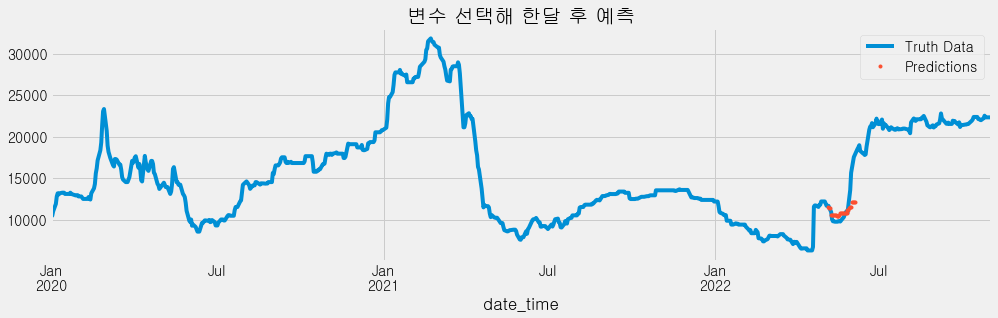

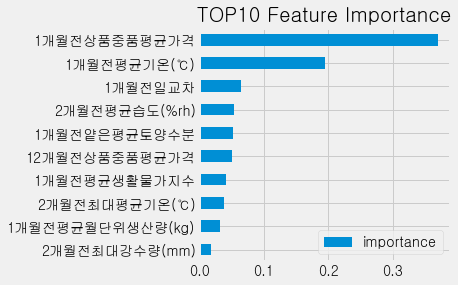

[0]	validation_0-rmse:15328.58215	validation_1-rmse:19936.48552
[100]	validation_0-rmse:5874.03783	validation_1-rmse:11133.76810
[200]	validation_0-rmse:2535.29707	validation_1-rmse:7619.68367
[300]	validation_0-rmse:1478.75719	validation_1-rmse:5863.12400
[400]	validation_0-rmse:1175.19504	validation_1-rmse:4678.04419
[500]	validation_0-rmse:1042.29792	validation_1-rmse:4144.25298
[600]	validation_0-rmse:934.52615	validation_1-rmse:3934.79473
[700]	validation_0-rmse:867.63813	validation_1-rmse:3705.58628
[800]	validation_0-rmse:812.57721	validation_1-rmse:3554.45315
[900]	validation_0-rmse:757.73821	validation_1-rmse:3440.70026
[1000]	validation_0-rmse:688.49233	validation_1-rmse:3364.05443
[1100]	validation_0-rmse:643.73154	validation_1-rmse:3295.17264
[1200]	validation_0-rmse:601.32128	validation_1-rmse:3257.09630
[1300]	validation_0-rmse:569.34014	validation_1-rmse:3214.12879
[1400]	validation_0-rmse:545.96261	validation_1-rmse:3173.68676
[1500]	validation_0-rmse:519.92379	validati

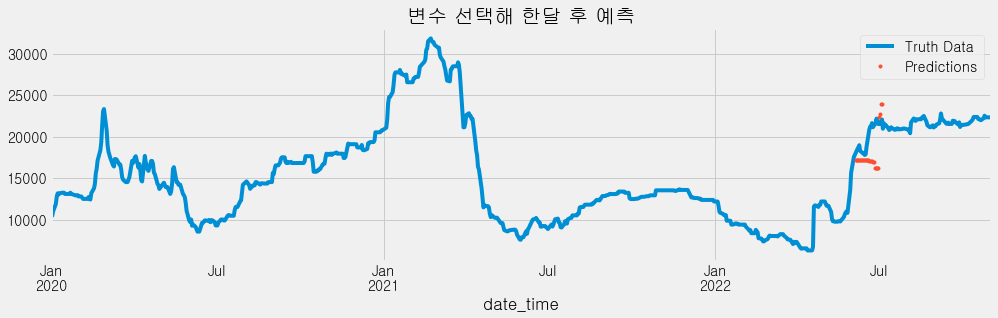

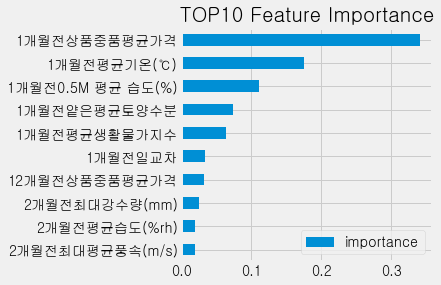

[0]	validation_0-rmse:15498.53639	validation_1-rmse:20831.43906
[100]	validation_0-rmse:5965.51099	validation_1-rmse:7625.51848
[200]	validation_0-rmse:2594.54749	validation_1-rmse:2778.60911
[300]	validation_0-rmse:1491.49241	validation_1-rmse:1014.74545
[400]	validation_0-rmse:1158.72421	validation_1-rmse:807.47948
[500]	validation_0-rmse:1004.98124	validation_1-rmse:779.31943
[530]	validation_0-rmse:962.53637	validation_1-rmse:823.61094


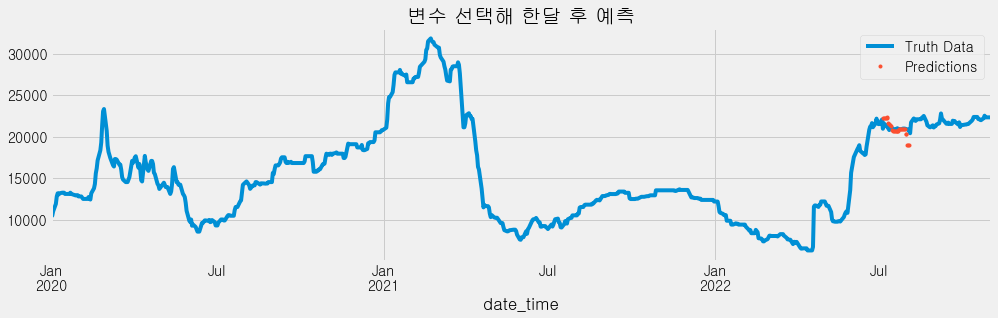

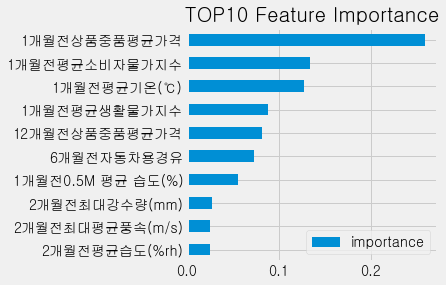

[0]	validation_0-rmse:15694.40529	validation_1-rmse:21558.03133
[100]	validation_0-rmse:6049.56918	validation_1-rmse:8920.81811
[200]	validation_0-rmse:2647.24524	validation_1-rmse:4183.93320
[300]	validation_0-rmse:1551.26990	validation_1-rmse:2518.69509
[400]	validation_0-rmse:1203.42955	validation_1-rmse:1960.16949
[500]	validation_0-rmse:1054.25720	validation_1-rmse:1641.03684
[600]	validation_0-rmse:960.85113	validation_1-rmse:1366.79627
[700]	validation_0-rmse:903.75935	validation_1-rmse:1252.10430
[800]	validation_0-rmse:843.53897	validation_1-rmse:1205.71067
[900]	validation_0-rmse:791.01671	validation_1-rmse:1169.60821
[964]	validation_0-rmse:768.48210	validation_1-rmse:1171.84306


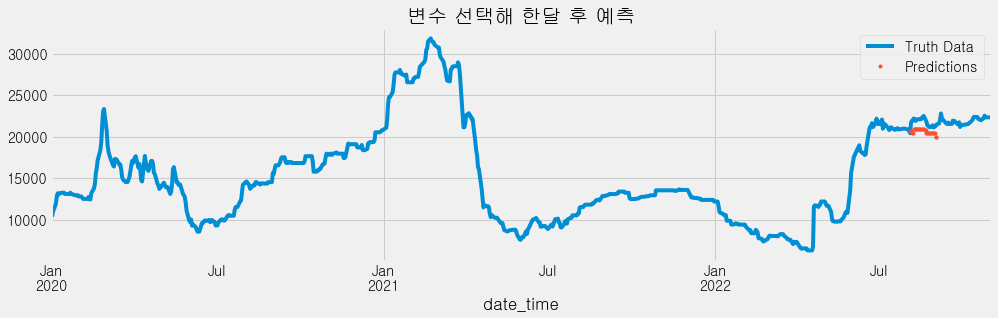

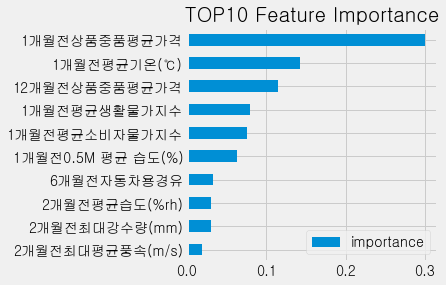

[0]	validation_0-rmse:15905.74727	validation_1-rmse:21503.61999
[100]	validation_0-rmse:6125.60492	validation_1-rmse:8390.40879
[200]	validation_0-rmse:2679.73742	validation_1-rmse:2736.01046
[300]	validation_0-rmse:1551.85242	validation_1-rmse:792.54144
[370]	validation_0-rmse:1260.96169	validation_1-rmse:814.95561


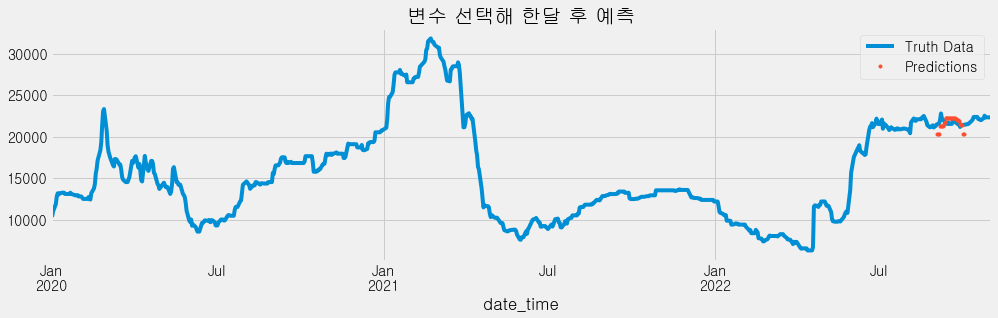

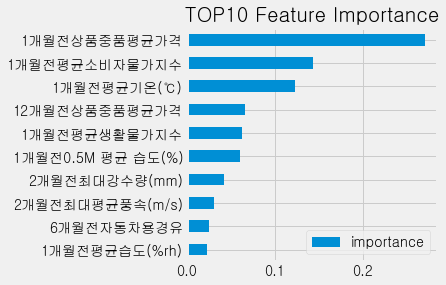

[0]	validation_0-rmse:16100.41440	validation_1-rmse:21876.07095
[100]	validation_0-rmse:6180.94345	validation_1-rmse:8552.84834
[200]	validation_0-rmse:2682.81419	validation_1-rmse:3420.21651
[300]	validation_0-rmse:1547.97683	validation_1-rmse:1533.53991
[400]	validation_0-rmse:1179.47498	validation_1-rmse:823.02791
[500]	validation_0-rmse:1037.86107	validation_1-rmse:562.01535
[600]	validation_0-rmse:949.79899	validation_1-rmse:466.07526
[700]	validation_0-rmse:882.14145	validation_1-rmse:451.53572
[800]	validation_0-rmse:836.45419	validation_1-rmse:449.56505
[804]	validation_0-rmse:834.66363	validation_1-rmse:448.53993


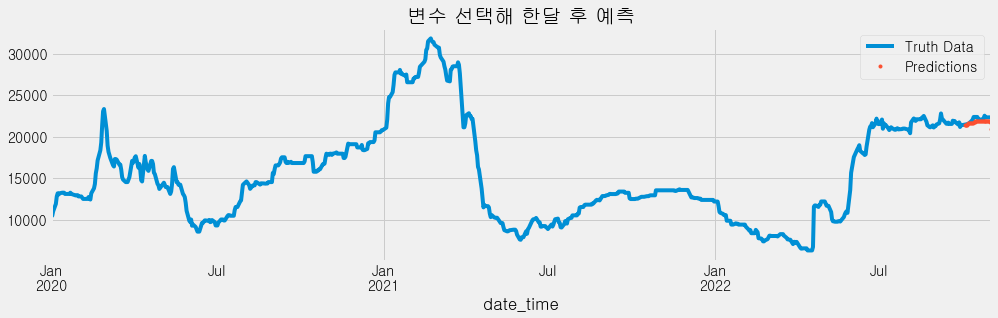

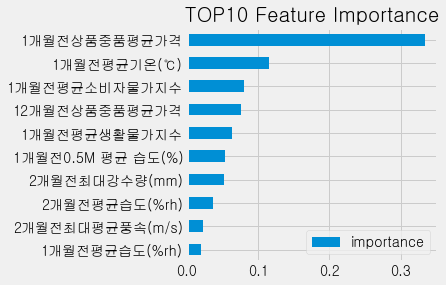

In [17]:
tss = TimeSeriesSplit(n_splits=6, test_size=30*1, gap=0)
new_df = new_df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(new_df):
    new_df2 = new_df.copy()
    train = new_df.iloc[train_idx]
    test = new_df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)


    FEATURES = [
          '1개월전평균풍속(m/s)','1개월전최대평균풍속(m/s)',
            '2개월전최대평균풍속(m/s)','1개월전일조율(%)',
            '재배면적합계(ha)','1년전10a당생산량(kg)', '1년전재배면적합계(ha)',
            '1년전연단위생산량(톤)','월단위생산량(kg)',
            '1개월전평균월단위생산량(kg)', '2개월전평균월단위생산량(kg)',
            '1개월전평균기온(℃)','1개월전평균습도(%rh)',
            '1개월전최대강수량(mm)', '1개월전최대평균기온(℃)',
            '2개월전최대강수량(mm)', '2개월전최대평균기온(℃)', 
            '1개월전강수량(mm)', '1개월전일조합(hr)','1개월전일교차',             
            '1개월전0.5M 평균 습도(%)', '1개월전얕은평균토양수분',
            'month', 'dayofweek', 'quarter', 
            '1개월전평균소비자물가지수', '1개월전평균생활물가지수', 
            '1개월전평균신선야채지수', '1개월전평균식품생활지수',
            '1개월전상품중품평균가격', '12개월전상품중품평균가격', '24개월전상품중품평균가격', 
            '2개월전얕은평균토양수분','2개월전강수량(mm)','2개월전평균습도(%rh)',
            '1개월전자동차용경유', '6개월전자동차용경유'
            ]
    
    TARGET = '상품중품평균가격'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
    test['prediction'] = reg.predict(X_test)
    new_df2 = new_df2.merge(test[['prediction']], how='left', left_index=True, right_index=True)
    ax = new_df2[['상품중품평균가격']].plot(figsize=(15, 4))
    new_df2['prediction'].plot(ax=ax, style='.')
    plt.legend(['Truth Data', 'Predictions'])
    ax.set_title('변수 선택해 한달 후 예측')
    plt.show()
    
    # Feature Importance plot
    fi = pd.DataFrame(data=reg.feature_importances_,
                 index=reg.feature_names_in_,
                 columns=['importance'])

    fi.sort_values('importance').tail(10).plot(kind='barh', title='TOP10 Feature Importance',figsize=(4,4))
    plt.show()